<a id='section7'></a>
# Index
1. [***Load and Check Package versions***](#section1)  
2. [***Analysis steps***](#section2) 
3. [***Load raw nerve signal***](#section3)
4. [***Load the stimulation times***](#section4)
5. [***Select segments for analysis***](#section5)
6. [***Save the Notebook***](#section6)

----------------   

----------------    

<a id='section1'></a>
## ***(1) Load and Check Python packages***
##### [back to top](#section7)

In [1]:
# load Python modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import neo
import pip
import sys

# use a plottign style in the notebook that is similar to ggplot2, see http://ggplot2.org/
plt.style.use('ggplot')
# plot the output of matplotlib commands in the notebook
%matplotlib inline

In [2]:
# Which version of Python is installed?
print(sys.version)

2.7.11 |Anaconda 2.5.0 (64-bit)| (default, Dec  6 2015, 18:08:32) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [3]:
# Which package versions are installed?
all_packages = pip.get_installed_distributions()
used_packages = ['pandas', 'numpy', 'matplotlib', 'neo', 'pip', 'sys']
for entry in used_packages:
    for p in all_packages:
        if entry in str(p):
            print(str(p))

pandas 0.17.1
numpy 1.10.4
matplotlib 1.5.1
neo 0.3.3
pip 8.1.1


<a id='section2'></a>
## ***(2) Analysis steps***
##### [back to top](#section7)

<a id='section3'></a>
## ***(3) Load raw nerve signal***
##### [back to top](#section7)

In [4]:
# make a directory if it does not exist
import os
if not os.path.exists("OUTPUT_FILES/"):
    os.makedirs("OUTPUT_FILES/")

In [5]:
# import a Spike2 file (CED)
filename='DATA_FILES/CAP.smr'; r= neo.Spike2IO(filename)
bl = r.read()[0]; asig = bl.segments[0].analogsignals[0]
# keep the signal as a 16 bit float
asig = np.float16(asig)
# adjust for amplifier gain (in this example it is 20,000 and signals are microvolts)
asig = asig * 50 
pts = float(np.prod(asig.shape)); secs = pts/20000.0; mins = secs/60.0; hrs = mins/60
print('{}:\n===================='.format(filename.split('/')[-1]))
print('{} data points\n{} sec\n{} min\n{} hr\n20,000 Hz'.format(
    pts, secs, mins, hrs))

CAP.smr:
401601.0 data points
20.08005 sec
0.3346675 min
0.00557779166667 hr
20,000 Hz


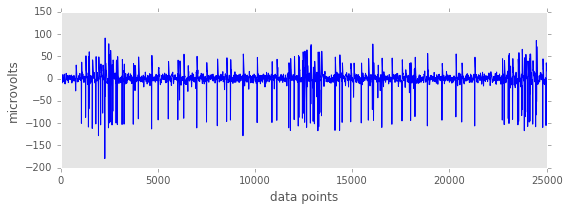

In [6]:
# plot data
# limit the time range
begin = 0; end = 25000
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(asig, 'b') # b = blue
ax.set_xlabel('data points', fontsize=12)
ax.set_ylabel('microvolts', fontsize=12)
ax.set_xlim(begin,end)
plt.grid()
plt.tight_layout()

In [7]:
# save data to an HDF5 file type to share
# first remove any previously created files from running this cell
import os
try:
    os.remove("OUTPUT_FILES/CAP.h5")
except OSError:
    pass
# use a start and end time in seconds (to select different parts of the file)
start = 0; end = 20; newfilename = "OUTPUT_FILES/CAP.h5"
# convert sec to pts using the sampling rate (20,000); adjust to match your files
start1 = start * 20000; end1 = end * 20000
# create the new array
new_asig = asig[start1:end1]
# Write a new Block>Segment>AnalogSignal Hierarchy from the ground up
# make a segment
seg = neo.Segment(); seg.name = 'New segment'
seg.description = 'Sample'; seg.index = 0
seg.analogsignals = []; seg.analogsignals.append(new_asig)
# make a recording channel
rec = neo.RecordingChannel(); rec.analogsignals = []
rec.analogsignals.append(new_asig)
# make a recording channel group
recg = neo.RecordingChannelGroup(); recg.recordingchannels = []
recg.recordingchannels.append(rec); recg.name = 'New group'
# make a block ... finally!
b = neo.Block(); b.name = 'New block'
b.segments = []; b.segments.append(seg)
b.recordingchannelgroups = []; b.recordingchannelgroups.append(recg)
# Write the block to a new HDF5 file:
w = neo.io.NeoHdf5IO(newfilename)
w.write_block(b)
w.close()

<a id='section4'></a>
## ***(4) Load the stimulation times***
##### [back to top](#section7)

### import stim, laser, and note for file 1

In [8]:
# provide column name for the times
colnames = ['Time']
# set the precision of decimal points
pd.set_option('precision', 5)
# read the csv file into pandas but skip 16 rows of the header information
stim_on = pd.read_csv('DATA_FILES/stim.txt', skiprows=16,names=colnames, index_col=False)
stim_on['Note'] = "stim-on"
# print the first 5
stim_on.head(5)

,Time,Note
0,5.01837,stim-on
1,5.51837,stim-on
2,6.01837,stim-on
3,6.51837,stim-on
4,7.01836,stim-on


<a id='section5'></a>
## ***(5) Select segments for analysis***
##### [back to top](#section7)

### Trial 1

      Time     Note
0  5.01837  stim-on
1  5.51837  stim-on
2  6.01837  stim-on
3  6.51837  stim-on
4  7.01836  stim-on
5  7.51836  stim-on
6  8.01836  stim-on
7  8.51836  stim-on
8  9.01826  stim-on
9  9.51826  stim-on


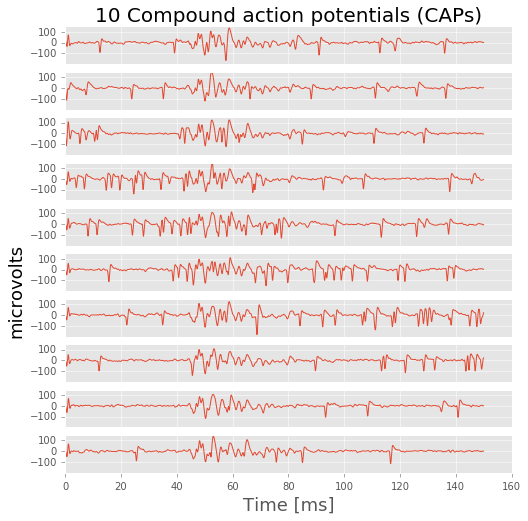

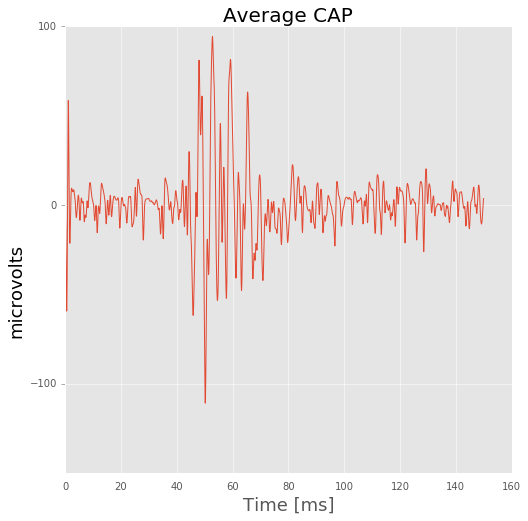

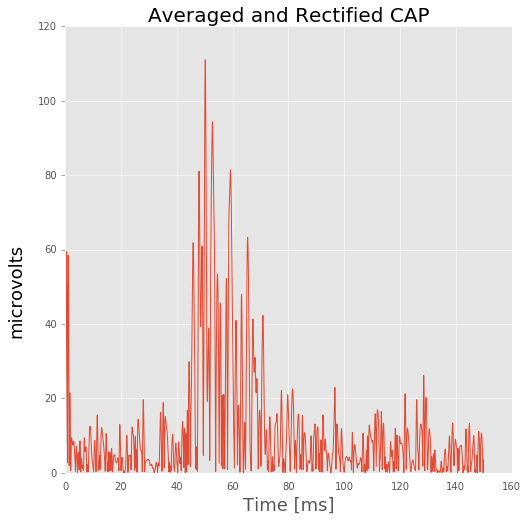

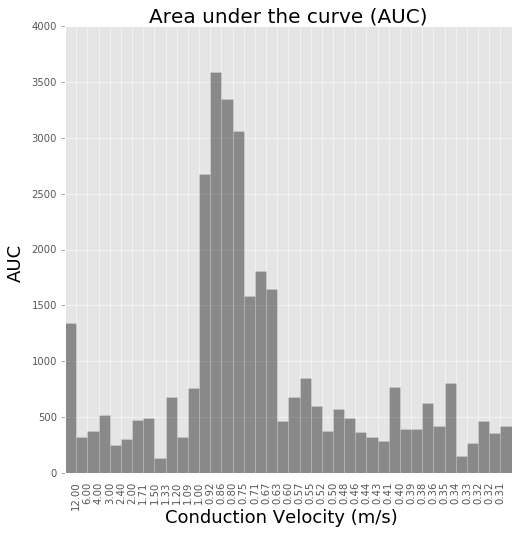

In [9]:
# [ENTER INFORMATION ... filename, length of vagus, and start and end times]
# file name
name = "trial1"
# vagus length in mm
vag_length = 40
# Select start and end times to detect all 10 Stim-on pulses
stims = stim_on.loc[(stim_on['Time'] > 4) & (stim_on['Time'] < 9.8) & (stim_on['Note'] == 'stim-on')]
# run the script
%run -i DATA_FILES/pulses_10_electrical.py
auc1 = np.array(FINAL1)

### Trial 2

        Time     Note
11  13.93096  stim-on
12  14.43096  stim-on
13  14.93086  stim-on
14  15.43086  stim-on
15  15.93086  stim-on
16  16.43087  stim-on
17  16.93087  stim-on
18  17.43087  stim-on
19  17.93087  stim-on
20  18.43087  stim-on


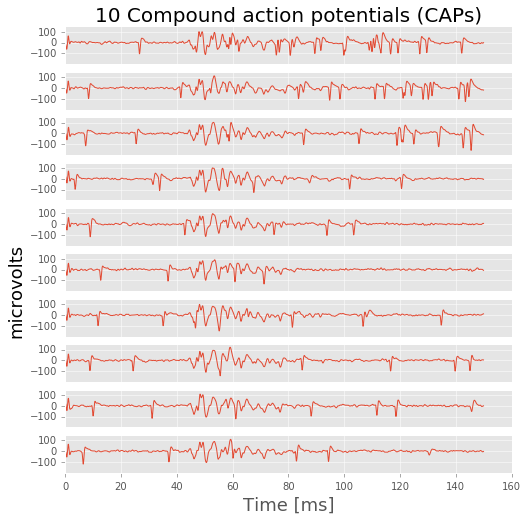

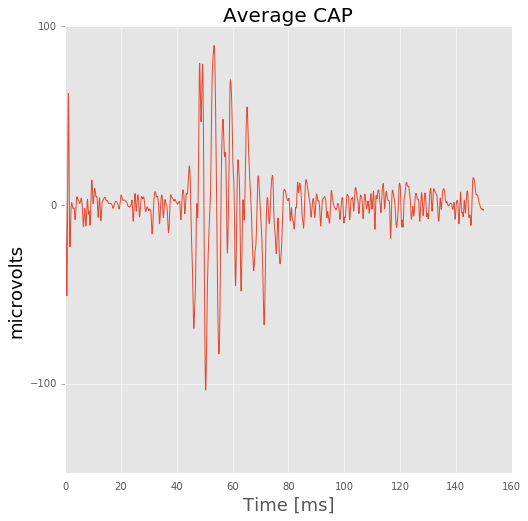

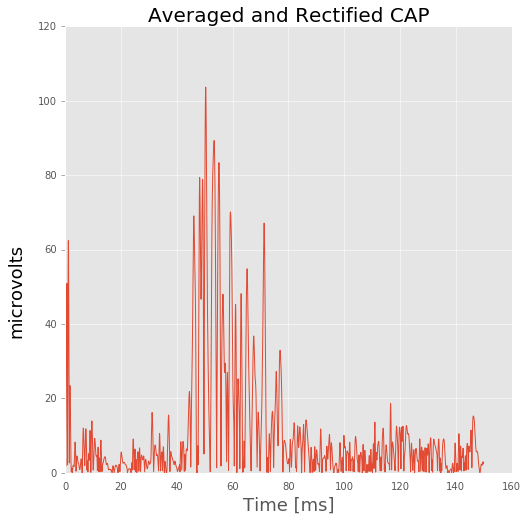

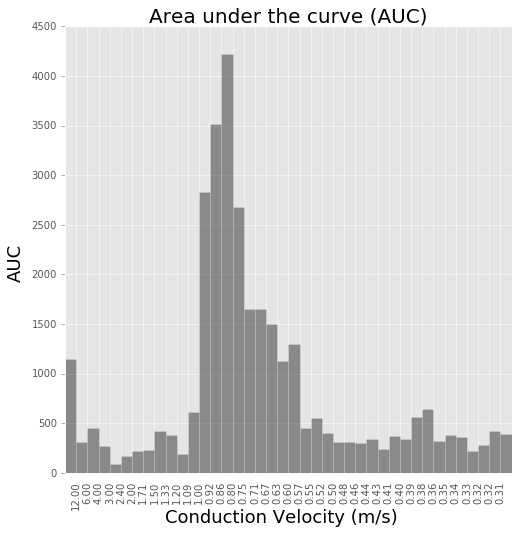

In [10]:
# [ENTER INFORMATION ... filename, length of vagus, and start and end times]
# file name
name = "trial2"
# vagus length in mm
vag_length = 40
# Select start and end times to detect all 10 Stim-on pulses
stims = stim_on.loc[(stim_on['Time'] > 13) & (stim_on['Time'] < 18.7) & (stim_on['Note'] == 'stim-on')]
# run the script
%run -i DATA_FILES/pulses_10_electrical.py
auc2 = np.array(FINAL1)

<a id='section6'></a>
## ***6) Save the Notebook***
##### [back to top](#section7)

In [11]:
# grabbing the name of the current notebook and printing the name
# if the print statement does not work, rerun the code for the following 3 cells

In [12]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NotebookName = '" + IPython.notebook.notebook_name + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [13]:
print(NotebookName) 

Compound-Action-Potentials.ipynb


In [14]:
## Saving the notebook to html and markdown
import os
import subprocess
subprocess.call('jupyter nbconvert '+NotebookName,shell=True)

0